In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from random import randint
import pickle,glob, cv2
from shared.segmentationHelpers import get_num_images, generate_image_segmentation_labels

In [2]:
def loadModel(configName):
    path = '../models/segmenters/'+configName+'/'
    modelPath = path + 'model'
    historyPath = path +'history.pickle'
    
    model = tf.keras.models.load_model(modelPath)
    with open(historyPath, 'rb') as f:
        history = pickle.load(f)
        
    return (model,history)

In [3]:
def showLoss(history):
    loss = history['loss']
    val_loss = history['val_loss']
    plt.plot(loss, label='Training')
    plt.plot(val_loss, label='Validation') 
    plt.ylabel('Loss (Binary CE)')
    plt.xlabel('Epoc')
    plt.legend()
    plt.show()

In [85]:
def diceScore(map1,map2):
    '''
    :param map1,map2 - are both binary matrices of depth 1
    '''
    mapIntersection = np.logical_and(map1,map2)
    
    intersection = sum(sum(mapIntersection))
    region1 = sum(sum(map1))
    region2 = sum(sum(map2))
    
    return (2*intersection)/(region1+region2)

def getAllMasks(method, segmentationScheme, dataDir):
    
    def flatten(image):
        imageNew = image[:,:,0]+image[:,:,1]+image[:,:,2]
        return imageNew
    
    def binarize(image):
        imageNew = np.zeros((image.shape),dtype='bool')
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                imageNew[i,j] = (image[i,j]>100)
                
        return imageNew
        
    
    masksPath = "{}/segmentation/{}/{}/labels/".format(dataDir,segmentationScheme,method)
    labelsPath = "{}/segmentation/{}/labels.pickle".format(dataDir,segmentationScheme)
    
    with open(labelsPath,'rb') as f:
        data = pickle.load(f)
    data = data[method]
    masks = [cv2.imread("{}{}.jpg".format(masksPath,image)) for image in data]
    masks = [flatten(mask) for mask in masks]
    masks = [binarize(mask) for mask in masks]
    
    return masks
    
def getAllPredictions(model, method,segmentationScheme,dataDir):
    BATCH_SIZE_TEST = 8
    NUM_SAMPLES_TEST =  get_num_images(method,segmentationScheme, dataDir)
    STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)    
    decoded_imgs = model.predict_generator(generate_image_segmentation_labels(method,segmentationScheme ,BATCH_SIZE_TEST, dataDir=dataDir,squashOutput=True),steps=STEPS_TEST)
    
    predictionsList = [decoded_imgs[i,:,:,0] for i in range(decoded_imgs.shape[0])]
    
    return predictionsList

def ThresholdPredictions(predictions, t_val=0.5):
    
    def threshold(image,t_val):
        imageNew = np.zeros((image.shape),dtype='bool')
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                imageNew[i,j] = (image[i,j]>t_val)
        return imageNew
    
    logicalMasks = [threshold(item,t_val)for item in predictions]
    return logicalMasks

def meanDiceScore(list1,list2):
    '''
    computes the mean dice score between 2 lists
    '''
    diceScores = [diceScore(list1[i],list2[i]) for i in range(len(list1))]
    total = sum(diceScores)
    mean = total/len(diceScores)
    return mean

def diceAtThresholds(actual,predicted, thresholds):
    
    meanDices = []
    for th in thresholds:
        thresholdedList = ThresholdPredictions(predicted,t_val = th)
        meanDice = meanDiceScore(actual,thresholdedList)
        print(meanDice)
        meanDices.append(meanDice)
        
    return meanDices

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


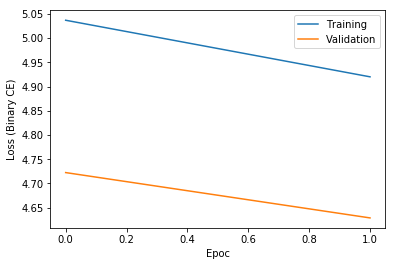

In [4]:
(model,history)=loadModel('config00')
showLoss(history)

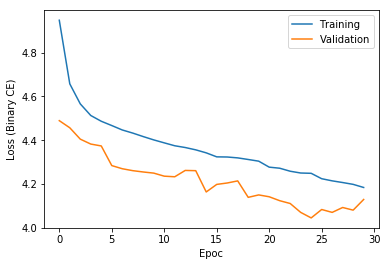

In [5]:
(model,history)=loadModel('config2')
showLoss(history)
#Decoding images
BATCH_SIZE_TEST = 8
NUM_SAMPLES_TEST =  get_num_images('test','foregroundBackground', '../data/')
STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)

decoded_imgs = model.predict_generator(generate_image_segmentation_labels('test','foregroundBackground' ,BATCH_SIZE_TEST, dataDir='../data/',squashOutput=True),steps=STEPS_TEST)

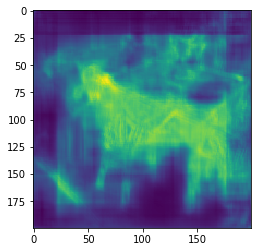

In [38]:
decoded_imgs.shape
plt.imshow(decoded_imgs[0,:,:,0])

In [83]:
labelMasks = getAllMasks('validation','foregroundBackground','../data/')
print('a')
(model,history)=loadModel('config2')
print('b')
predicted = getAllPredictions(model,'validation','foregroundBackground','../data/')
print('c')

a
b
c
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.9011915374289462, 0.9011915374289462, 0.9011915374289462, 0.9011915374289462, 0.9011915374289462, 0.9011915374289462, 0.9011915374289462, 0.9011915374289462, 0.9011915374289462]


In [86]:
t_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
curve = diceAtThresholds(labelMasks,predicted, t_list)
print(t_list)
print(curve)

0.48699119828558357
0.5656590283858238
0.5755411490817375
0.5614821690857602
0.5258928798068393
0.4401575554141006
0.25972413189302057
0.08232096993108669
0.009754155138941534
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.48699119828558357, 0.5656590283858238, 0.5755411490817375, 0.5614821690857602, 0.5258928798068393, 0.4401575554141006, 0.25972413189302057, 0.08232096993108669, 0.009754155138941534]


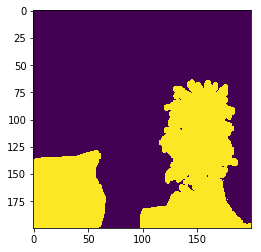

In [76]:
ind = 2
plt.imshow(labelMasks[ind])

0.5033622371104594

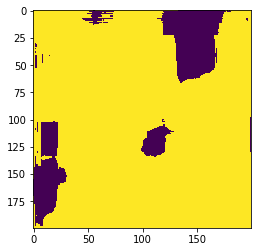

In [78]:
plt.imshow(threshed[ind])
meanDiceScore(threshed,labelMasks)